Nuevamente, basado en el gran trabajo de Manuel Ferreira de @mattewithcoffee 

https://twitter.com/Matewithcoffee

https://www.youtube.com/watch?v=lz-Csu3ce4s&feature=youtu.be

In [361]:
# Carga de librerías
import pandas as pd
import pandas_datareader as pdr
import numpy as np

# Librearías gráficas
import matplotlib.pyplot as plt
import mplfinance as mpf

In [362]:
# Descarga de Cotización y limpieza
ticket = 'MIRG.BA'
df = pdr.get_data_yahoo(ticket,'06-24-2019')
df = df[df['Volume']>0]
df = df.drop('Adj Close', axis=1)
df.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume'], dtype='object')

In [363]:
# Hasta ahí no hay nada nuevo
# Manuel Ferreira: MEDIA MOVIL SIMPLE
df['SMA_7'] = df.iloc[:,3].rolling(window=7).mean()

# Media Móvil Exponencial
df['EMA_7'] = df.iloc[:,3].ewm(span=7, adjust=False).mean()

# Media Móvil Acumulada
df['CMA_7'] = df.iloc[:,3].expanding(min_periods=7).mean()

# Doble Media Móvil Exponencial
df['2_EMA_7'] = df.EMA_7.ewm(span=7, adjust=False).mean()
df['2_x_EMA_7'] = 2*(df['2_EMA_7'])
df['DEMA_7'] = df['2_x_EMA_7'] - df['2_EMA_7']

# Triple Media Móvil Exponencial
df['3_EMA_7'] = df['2_EMA_7'].ewm(span=7, adjust=False).mean() # Media Movil Exponencial de la EMA de la EMA n=12
df['TEMA_7'] = (3*df['EMA_7'])-(3*df['2_EMA_7'])+df['3_EMA_7']

# TRIMA Media Móvil Triangular
df['TRIMA_7'] = df.SMA_7.rolling(window=7).mean()

# MACD
df['12d_EMA'] = df.iloc[:,3].ewm(span=12, adjust=False).mean()
df['26d_EMA'] = df.iloc[:,3].ewm(span=26, adjust=False).mean()
df['MACD'] = df['12d_EMA']- df['26d_EMA'] 

# Calcula MACD
df['MACD_signal'] = df.MACD.ewm(span=9, adjust=False).mean() 

# Calcula Fuerza de la Tendencia
df['Strength'] = (df['MACD']-df['MACD_signal'])



In [364]:
# Visualización en tabla de todos
df[['Close','MACD','MACD_signal','TRIMA_7','TEMA_7','DEMA_7','CMA_7','EMA_7','SMA_7','Strength']]

,Close,MACD,MACD_signal,TRIMA_7,TEMA_7,DEMA_7,CMA_7,EMA_7,SMA_7,Strength
Date,,,,,,,,,,
2019-06-24,339.0,0.000000,0.000000,NaN,339.000000,339.000000,NaN,339.000000,NaN,0.000000
2019-06-25,338.0,-0.079772,-0.015954,NaN,338.421875,338.937500,NaN,338.750000,NaN,-0.063818
2019-06-26,337.5,-0.181249,-0.049013,NaN,337.816406,338.812500,NaN,338.437500,NaN,-0.132235
2019-06-27,344.5,0.299717,0.020733,NaN,341.546875,339.097656,NaN,339.953125,NaN,0.278984
2019-06-28,343.0,0.553468,0.127280,NaN,342.749512,339.501953,NaN,340.714844,NaN,0.426189
...,...,...,...,...,...,...,...,...,...,...
2020-06-19,819.0,35.289220,43.336649,823.448980,801.260162,809.608462,539.149378,809.601027,814.285714,-8.047429
2020-06-22,831.5,34.801587,41.629637,822.163265,816.007116,810.975289,540.357438,815.075770,812.357143,-6.828050
2020-06-23,872.0,37.253708,40.754451,821.816327,847.914760,815.558174,541.722222,829.306828,822.785714,-3.500743


In [365]:
# Cálculo de RSI

deltas = df.iloc[:,3].diff()
seed = deltas[:14+1]
up = seed[seed >= 0].sum()/14
down = -seed[seed < 0].sum()/14

rs = up/down
rsi = np.zeros_like(df.iloc[:,3])
rsi[:14] = 100. - 100./(1.+rs)


for i in range(14, len(df.iloc[:,3])):
    delta = deltas[i-1]  # cause the diff is 1 shorter

    if delta > 0:
        upval = delta
        downval = 0.
    else:
        upval = 0.
        downval = -delta

    up = (up*(14-1) + upval)/14
    down = (down*(14-1) + downval)/14

    rs = up/down
    rsi[i] = 100. - 100./(1.+rs)

    
df['RSI'] = rsi

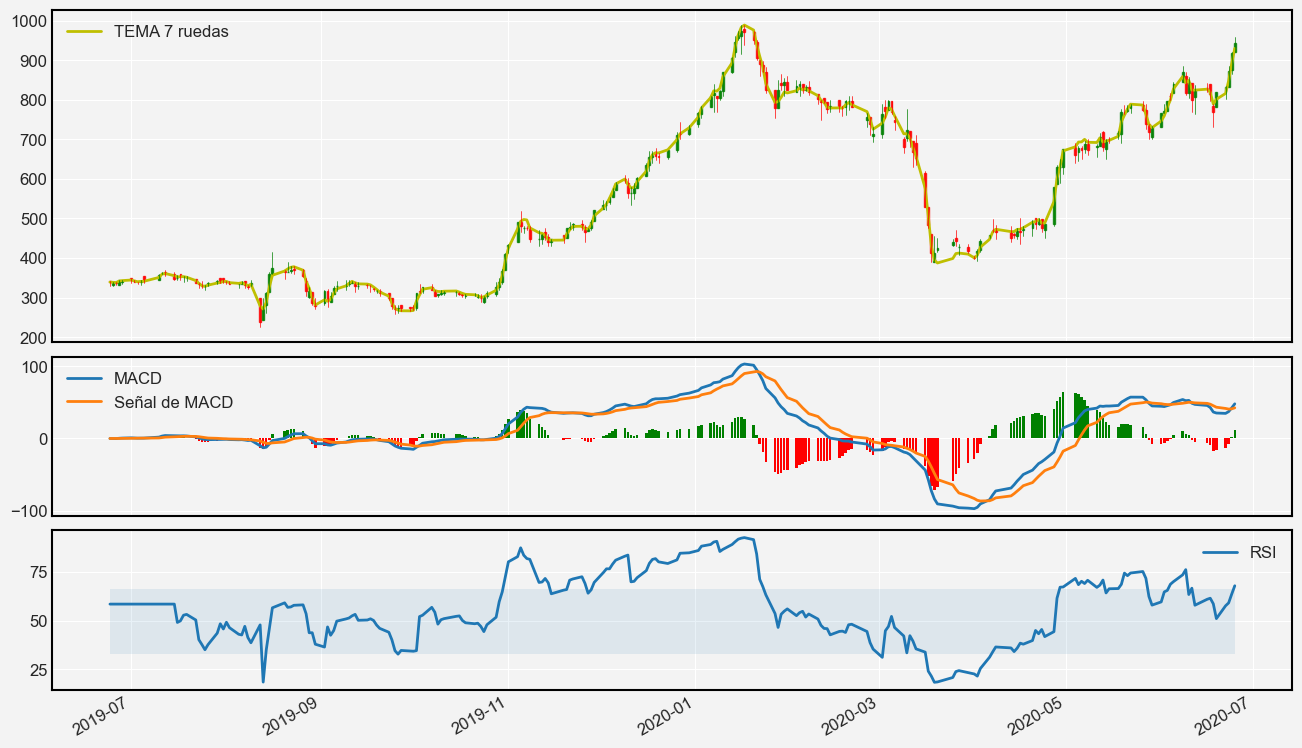

In [368]:
# Preparar grilla de charts
fig = plt.figure(facecolor='#f3f3f3',figsize=(16,10))

ax0 = plt.subplot2grid((8,3), (0,0), rowspan=4, colspan=3, facecolor='#f3f3f3')

ax1 = plt.subplot2grid((8,3),(4,0), sharex=ax0, rowspan=2, colspan=3, facecolor='#f3f3f3')
ax2 = plt.subplot2grid((8,3),(6,0), sharex=ax0, rowspan=2, colspan=3, facecolor='#f3f3f3')
fig.autofmt_xdate()
fig.set_label(ticket)
fig.set_figsize=(20, 10)

# Charts de valores
ax0.grid(True)
ax0.figsize=(20, 7)
#ax0.plot(df.index,df['Close'],label='Cierre',linestyle='dashed')
ax0.plot(df.index,df['TEMA_7'],label='TEMA 7 ruedas',color='y')

ohlc = df.reset_index().loc[:, ['Date', 'Open', 'High', 'Low', 'Close','Volume']]
ohlc['Date'] = pd.to_datetime(ohlc['Date'])
ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
candlestick_ohlc(ax0, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)

ax0.legend()

# Chart de MACD, MACD_signal, Fortaleza
ax1.grid(True)
ax1.plot(df['MACD'],label='MACD')
ax1.plot(df['MACD_signal'],label='Señal de MACD')
ax1.bar(df.index,df['Strength'].gt(0)*df['Strength']*2,color='g')
ax1.bar(df.index,df['Strength'].lt(0)*df['Strength']*2,color='r')
ax1.legend()

# Chart de RSI
ax2.grid(True)
ax2.plot(df['RSI'],label='RSI')
ax2.fill_between(df.index, 66, 33, alpha=0.1)
ax2.legend()